# HW10, Assignment 2 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

#### This is a lab prepared by Dr. Kashuk. Except where specified by a comment, code is as provided in the lab. Explanatory captions for plots are provided by Sofiya Elyukin, and some variables were renamed for better clarity.

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import matplotlib.patches as mpatches
import statsmodels.api as sm
import shapely
import pysal as ps

## Access the data within the notebook

In [3]:
# Addition to notebook from se1296

# CitiBike Station Locations
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/Station_id.csv"
!mv "Station_id.csv" "Data/Station_id.csv"

# Monthly CitiBike Usage
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CitiBike_monthly_byStation.csv"
!mv "CitiBike_monthly_byStation.csv" "Data/CitiBike_monthly_byStation.csv"

# 2010 Census Data
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/ACS_CT2010.csv"
!mv "ACS_CT2010.csv" "Data/ACS_CT2010.csv"

# Census Tract 2010 Shapefiles
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.cpg"
!mv "ct_shape.cpg" "Data/ct_shape.cpg"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.dbf"
!mv "ct_shape.dbf" "Data/ct_shape.dbf"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shp"
!mv "ct_shape.shp" "Data/ct_shape.shp"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.prj"
!mv "ct_shape.prj" "Data/ct_shape.prj"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shx"
!mv "ct_shape.shx" "Data/ct_shape.shx"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/R10_BoroCT2010.csv"
!mv "R10_BoroCT2010.csv" "Data/R10_BoroCT2010.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16006  100 16006    0     0  52268      0 --:--:-- --:--:-- --:--:--  332k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77643  100 77643    0     0   369k      0 --:--:-- --:--:-- --:--:-- 1038k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2405k  100 2405k    0     0  7529k      0 --:--:-- --:--:-- --:--:-- 12.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0    10    0    10    0     0     60      0 --:--:-- --:--:-- --:--:--   294
  % Total    % Received % Xferd  Average Speed   Tim

## Working with Shape File

### Loading Census Tract Shape File¶

In [4]:
#using GeoDataFrame from geopandas
shape_path="Data/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path) # this is the shapefile
ct_shape.index=ct_shape.BoroCT2010 # the census tract is now the index, this will allow joining datasets later

### Coordinate systems, projections, and transformations 

In [5]:
# using from_espg from fiona.crs
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'Total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

Total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

In [6]:
# se1296 adding code to spruce up plot, 
# http://matplotlib.org/users/legend_guide.html
red_patch = mpatches.Patch(color='red', label='Manhattan')
green_patch = mpatches.Patch(color='green', label='Bronx')
orange_patch = mpatches.Patch(color='orange', label='Brooklyn')
brown_patch = mpatches.Patch(color='brown', label='Queens')
gray_patch = mpatches.Patch(color='gray', label='Staten Island')

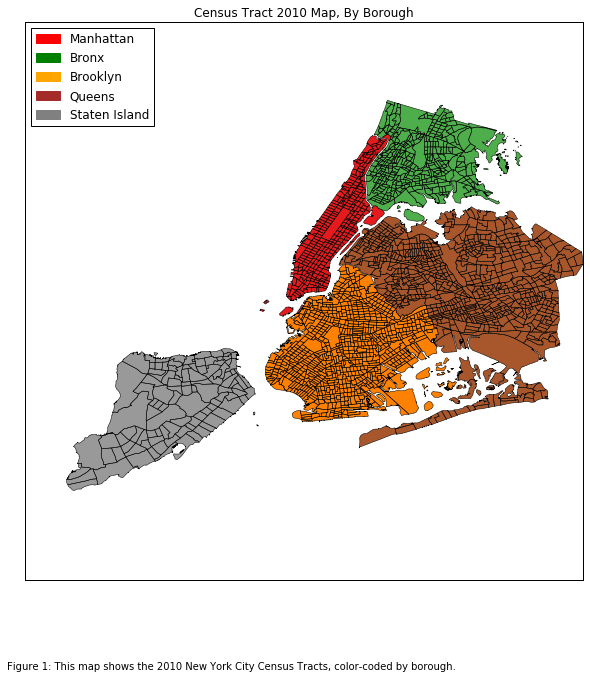

In [7]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax) 
plt.title("Census Tract 2010 Map, By Borough")
plt.legend(handles=[red_patch, green_patch, orange_patch, brown_patch, gray_patch], loc='upper left') #se1296
plt.figtext(0.1, -0.0000001, '''Figure 1: This map shows the 2010 New York City Census Tracts, color-coded by borough.''',
            fontsize='medium') #se1296

### Map NYC Population density

#### Load Census Data for 2010

In [8]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [9]:
# with "join" you don't specify a column like for merge. it joins based on index
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


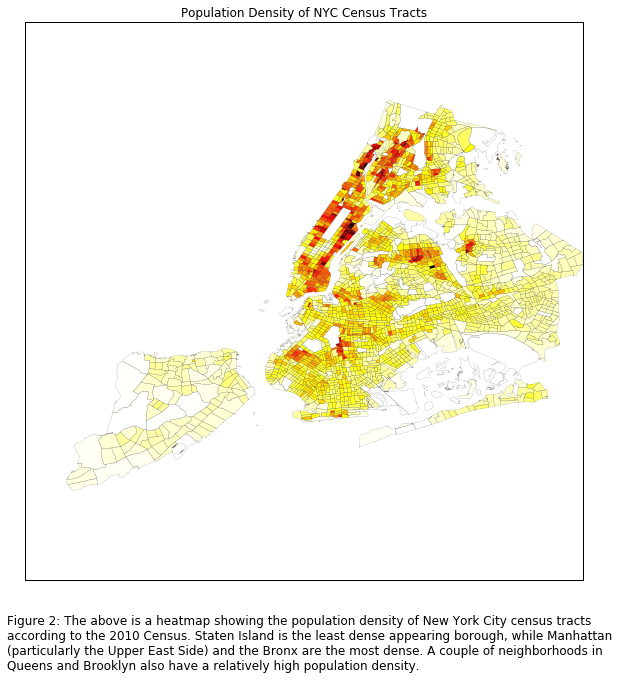

In [10]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density of NYC Census Tracts")
plt.figtext(0.1, -0.00001, '''Figure 2: The above is a heatmap showing the population density of New York City census tracts
according to the 2010 Census. Staten Island is the least dense appearing borough, while Manhattan
(particularly the Upper East Side) and the Bronx are the most dense. A couple of neighborhoods in
Queens and Brooklyn also have a relatively high population density.''',
            fontsize='large') #se1296

## Explore CitiBike data

### Load CitiBike data

In [11]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


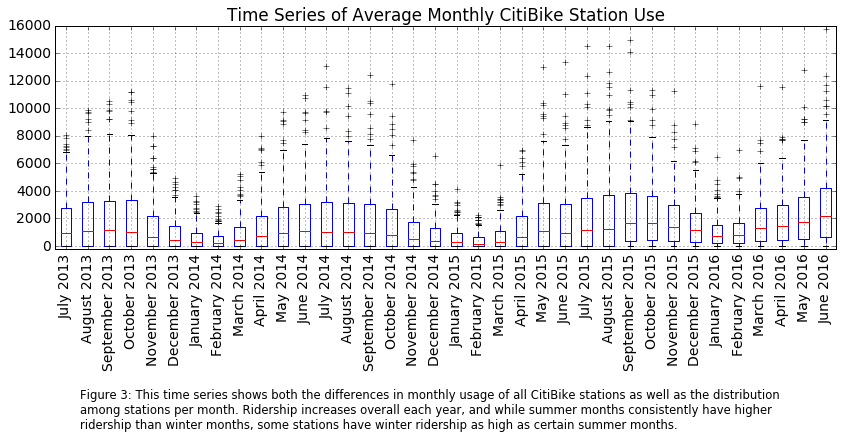

In [12]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
plt.title('Time Series of Average Monthly CitiBike Station Use')
plt.figtext(0.15, -.5, '''Figure 3: This time series shows both the differences in monthly usage of all CitiBike stations \
as well as the distribution
among stations per month. Ridership increases overall each year, and while summer months consistently have higher
ridership than winter months, some stations have winter ridership as high as certain summer months.''',
            fontsize='small') #se1296

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


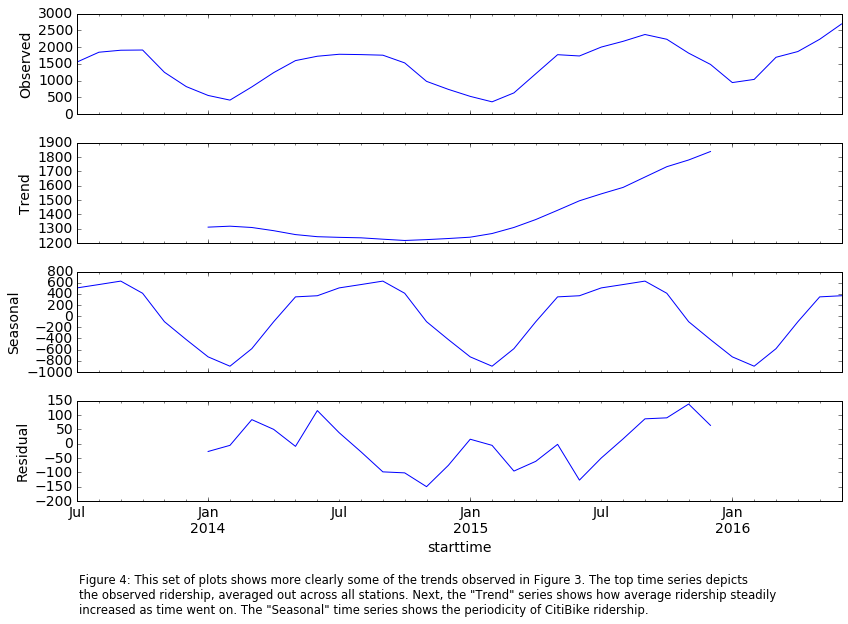

In [13]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_monthly_avg=df_bike_monthly.mean(1).resample('M').mean()
df_monthly_avg.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_monthly_avg.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot() #this is all 4 graphs
plt.figtext(0.1, -0.08, '''Figure 4: This set of plots shows more clearly some of the trends observed in Figure 3. \
The top time series depicts 
the observed ridership, averaged out across all stations. Next, the "Trend" series shows how average ridership steadily
increased as time went on. The "Seasonal" time series shows the periodicity of CitiBike ridership.''',
            fontsize='small') #se1296

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [14]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [15]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry based on lonlat column using shapely
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [16]:
CTcodes=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    CTcodes.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4], 
station_id['BoroCT2010']=CTcodes

% 100.


In [17]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

##### se1296 note for comprehension: the above code functioned as a "spatial join". The station geometries were intersected with the census tract geometries, and for each station a value of TRUE was returned for the one and only tract whose geometry the station fell within. The code for that tract was then appended into a new column in the station_id dataframe.

### Add Monthly rides to the station GeoDataFrame with CT code
The code in this section to separate winter and summer months is mine

#### First, separate winter and summer months

In [18]:
# warm vs cold weather separation
# bike_summer = df_bike_monthly[(df_bike_monthly.index.month > 3) & (df_bike_monthly.index.month < 10)]
# bike_winterA = df_bike_monthly[(df_bike_monthly.index.month < 4)]
# bike_winterB = df_bike_monthly[(df_bike_monthly.index.month > 9)]
# bike_winter = bike_winterA.append(bike_winterB)

In [19]:
bike_summer = df_bike_monthly[(df_bike_monthly.index.month > 5) & (df_bike_monthly.index.month < 10)]
bike_winterA = df_bike_monthly[(df_bike_monthly.index.month < 4)]
bike_winterB = df_bike_monthly[(df_bike_monthly.index.month == 12)]
bike_winter = bike_winterA.append(bike_winterB)

In [20]:
bike_winter.sort_index(inplace=True)

In [21]:
print len(bike_summer), len(df_bike_monthly), len(bike_winter)
bike_winter.head()

12 36 12


,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0
2014-12-31,1052,1304,4501,1783,2985,2091,779,2108,1636,878,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Check type for stations that didn't exist in certain months
#bike_summer.head()
#type(bike_summer['1533'][3])

In [23]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['WinterAvg']=bike_winter.mean()
station_id['SummerAvg']=bike_summer.mean()

In [24]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,WinterAvg,SummerAvg
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1096.916667,2558.000000
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,1342.750000,3830.500000
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,4411.666667,9903.083333
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,1628.416667,3732.833333
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,2609.916667,6895.750000


### Add the monthly average rides to the CT shapefile 
From here the code is mostly as provided in the lab, with adjustments to use the seasonal data rather than overall monthly data, and to create side-by-side plots for comparison.

In [25]:
summer=station_id[['SummerAvg']]
summer['station_id']=station_id.index
summer.index=station_id['BoroCT2010']
ct_shape_Summer=ct_shape.join(summer)
ct_shape_Summer.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [26]:
winter=station_id[['WinterAvg']]
winter['station_id']=station_id.index
winter.index=station_id['BoroCT2010']
ct_shape_Winter=ct_shape.join(winter)
ct_shape_Winter.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


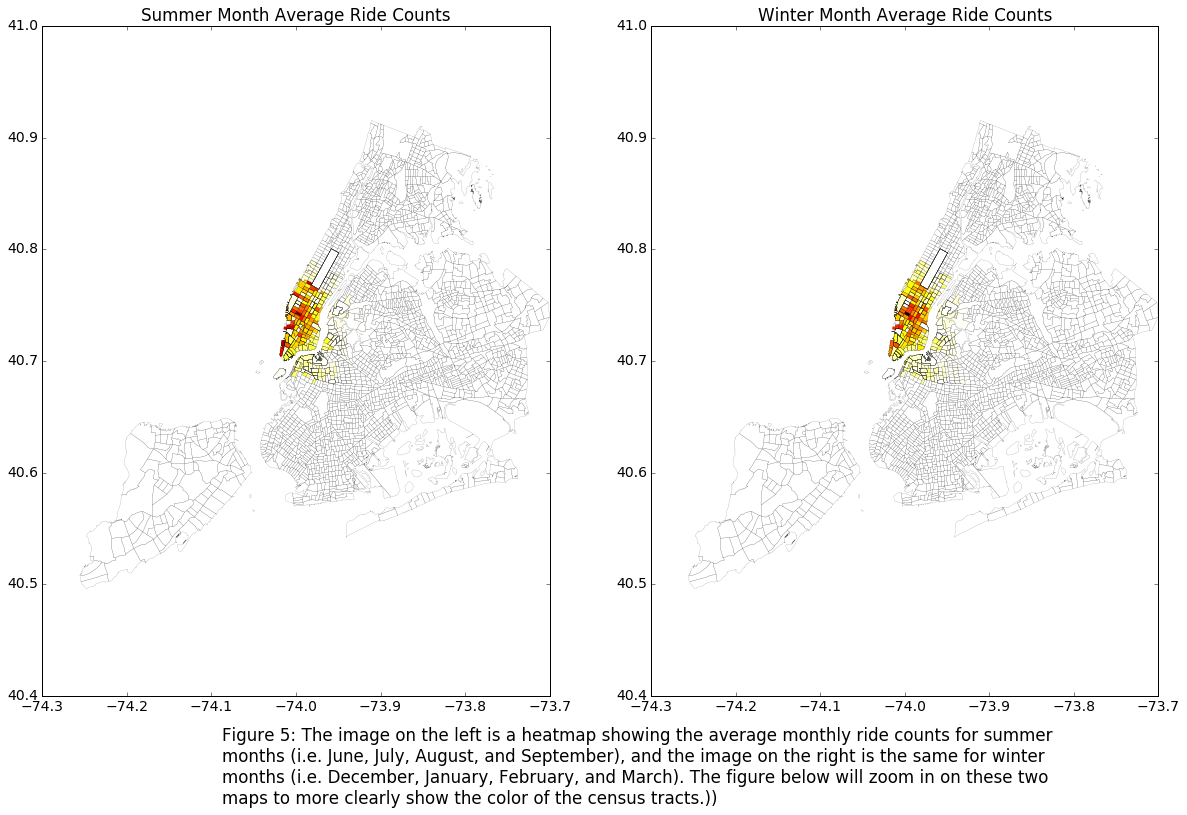

In [27]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,12))
ct_shape_Summer.plot(column='SummerAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Summer Month Average Ride Counts")
ct_shape_Winter.plot(column='WinterAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Winter Month Average Ride Counts")
plt.figtext(0.25, -0.00001, '''Figure 5: The image on the left is a heatmap showing the average monthly ride counts for summer 
months (i.e. June, July, August, and September), and the image on the right is the same for winter 
months (i.e. December, January, February, and March). The figure below will zoom in on these two
maps to more clearly show the color of the census tracts.))''',
            fontsize='large')

### Removing the CTs that are out of zoom boundries

In [28]:
ct_shape_Summer_Zoom=(ct_shape_Summer[ct_shape_Summer
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])
ct_shape_Winter_Zoom=(ct_shape_Winter[ct_shape_Winter
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [29]:
print "Total number of Census Tracts:", len(ct_shape)
print "Number of zoomed Census Tracts (Summer):", len(summer.SummerAvg)
print "Number of zoomed Census Tracts (Winter):", len(winter.WinterAvg)

Total number of Census Tracts: 2166
Number of zoomed Census Tracts (Summer): 543
Number of zoomed Census Tracts (Winter): 543


### Map the monthly rides 

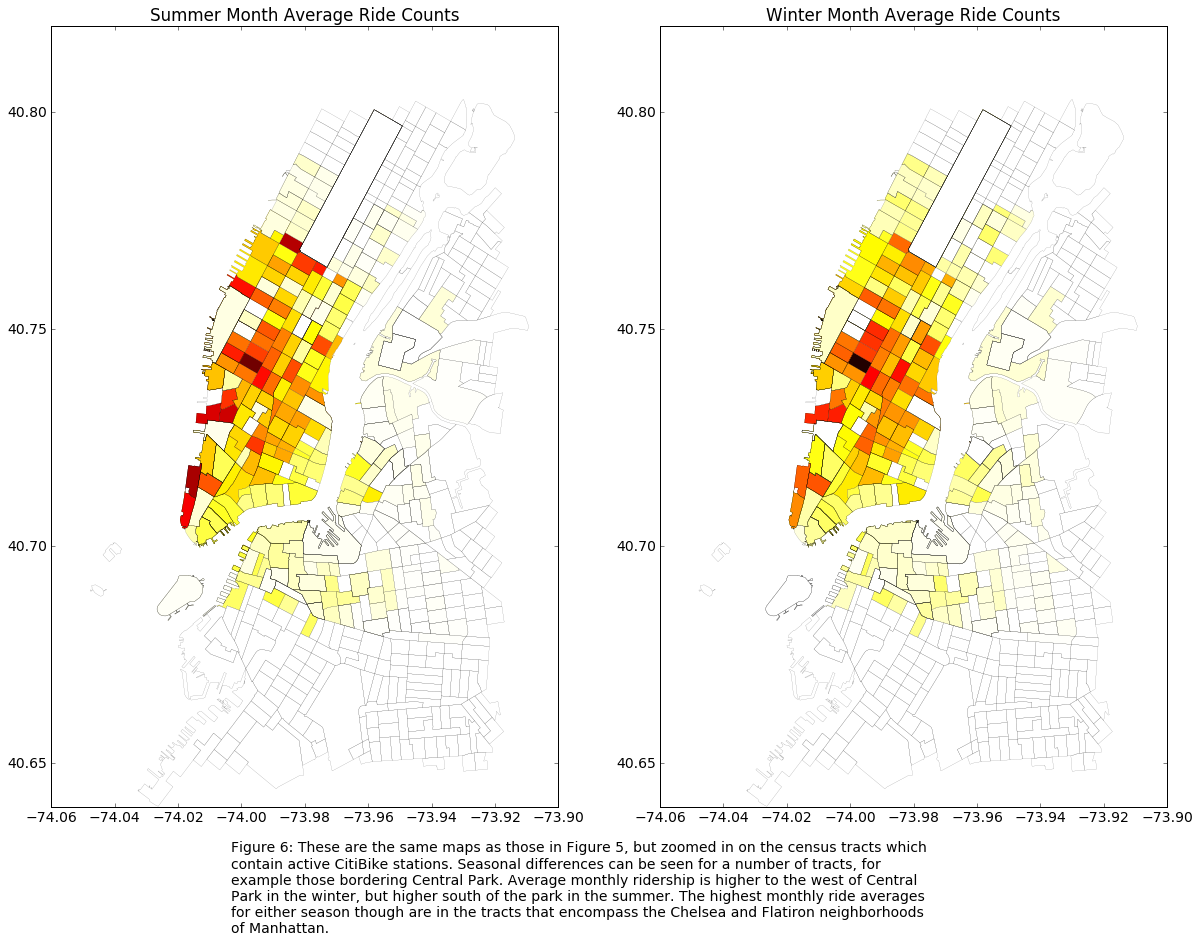

In [30]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_Summer_Zoom.plot(column='SummerAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Summer Month Average Ride Counts")
ct_shape_Winter_Zoom.plot(column='WinterAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Winter Month Average Ride Counts")
plt.figtext(0.25, -0.00008, '''Figure 6: These are the same maps as those in Figure 5, but zoomed in on the census tracts which
contain active CitiBike stations. Seasonal differences can be seen for a number of tracts, for
example those bordering Central Park. Average monthly ridership is higher to the west of Central
Park in the winter, but higher south of the park in the summer. The highest monthly ride averages 
for either season though are in the tracts that encompass the Chelsea and Flatiron neighborhoods
of Manhattan. ''')

### Export Shapefile CTs in the CitiBike Zone

In [31]:
path1='Output/ct_shape_Summer_Zoom.shp'
path2='Output/ct_shape_Winter_Zoom.shp'
ct_shape_Summer_Zoom.to_file(path1)
ct_shape_Winter_Zoom.to_file(path2)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [32]:
# using pysal
queenWeights_Summer=ps.queen_from_shapefile(path1)
queenWeights_Winter=ps.queen_from_shapefile(path2)

('Island id: ', [0])
('Island id: ', [0])


#### Neighbors of index10

In [33]:
print queenWeights_Summer[10]
print queenWeights_Winter[10]

{1: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0}
{1: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0}


In [34]:
print queenWeights_Summer.cardinalities[10] # how many neighbors (i.e. count above output)
queenWeights_Winter.cardinalities[10]

9


9

#### Matrix of Weights

In [35]:
WmatrixSmr, ids = queenWeights_Summer.full()
WmatrixWtr, ids = queenWeights_Winter.full()

In [36]:
print WmatrixSmr
print WmatrixWtr

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 0.  0.  0. ...,  0.  1.  0.]]


#### Change the matrix to be row-standardized

In [37]:
queenWeights_Summer.transform = 'r'
queenWeights_Winter.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neighbors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [38]:
SummerRide=ct_shape_Summer_Zoom.SummerAvg
SummerRideLag=ps.lag_spatial(queenWeights_Summer, SummerRide)

WinterRide=ct_shape_Winter_Zoom.WinterAvg
WinterRideLag=ps.lag_spatial(queenWeights_Winter, WinterRide)

#### Create Quantiles for maping

In [39]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
print SummerRideLagQ10
print WinterRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    7.333                 2
   7.333 < x[i] <=  125.969                78
 125.969 < x[i] <=  256.250                80
 256.250 < x[i] <=  629.283                81
 629.283 < x[i] <=  968.988                78
 968.988 < x[i] <= 2141.150                79
2141.150 < x[i] <= 3116.268                80
3116.268 < x[i] <= 3599.888                79
3599.888 < x[i] <= 5503.042                80
                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    4.595                 2
   4.595 < x[i] <=   75.189                78
  75.189 < x[i] <=  180.444                80
 180.444 < x[i] <=  287.743                79
 287.743 < x[i] <=  417.840                80
 417.840 < x[i] <=  937.426                79
 937.426 < x[i] <= 1267.157   

#### Map the monthly rides lag

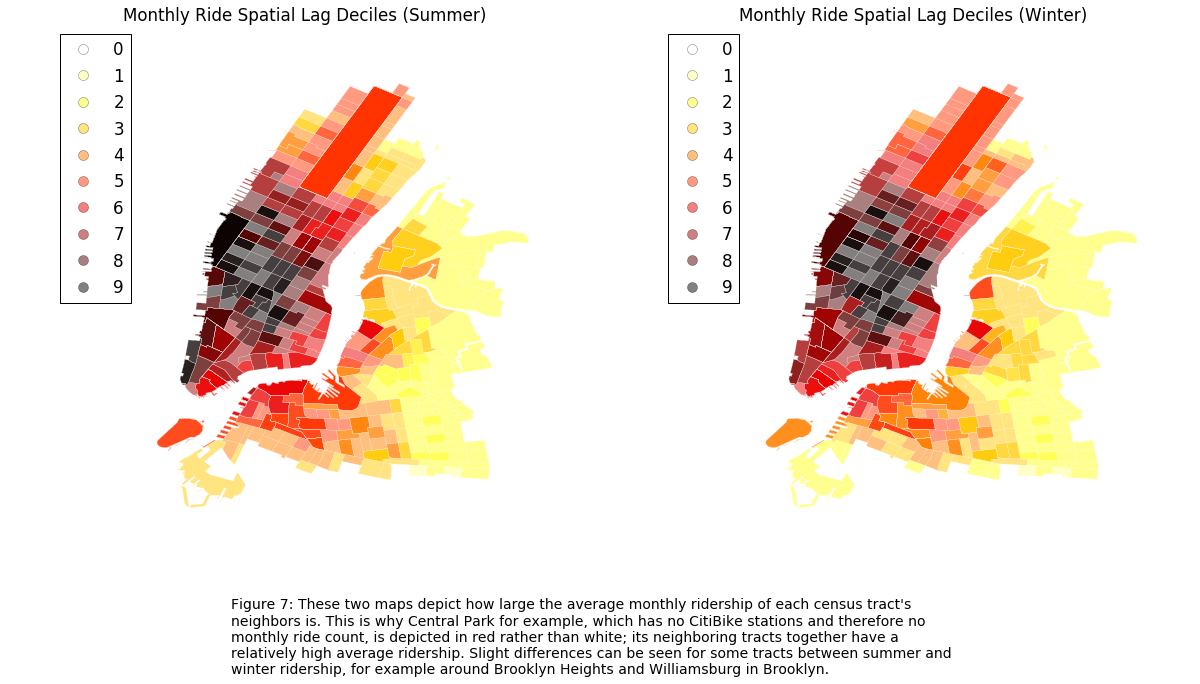

In [40]:
# This map is pointless? --> can't interpret it yet. The current color value of each tract is a representation of its neighbors,
# not itself. I.e., if tract has high value, it just means its neighbors have a high value
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
ct_shape_Summer_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ct_shape_Winter_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title("Monthly Ride Spatial Lag Deciles (Summer)")
ax2.set_title("Monthly Ride Spatial Lag Deciles (Winter)")
plt.figtext(0.25, -0.00008, '''Figure 7: These two maps depict how large the average monthly ridership of each census tract's
neighbors is. This is why Central Park for example, which has no CitiBike stations and therefore no
monthly ride count, is depicted in red rather than white; its neighboring tracts together have a
relatively high average ridership. Slight differences can be seen for some tracts between summer and 
winter ridership, for example around Brooklyn Heights and Williamsburg in Brooklyn.''')

## Global  Spatial Autocorrelation

In [41]:
b,a = np.polyfit(SummerRide, SummerRideLag, 1)
print b,a 
d,c = np.polyfit(WinterRide, WinterRideLag, 1)
print d, c

0.643893143126 473.577589895
0.661894622507 194.318136773


### Moran Scatterplot

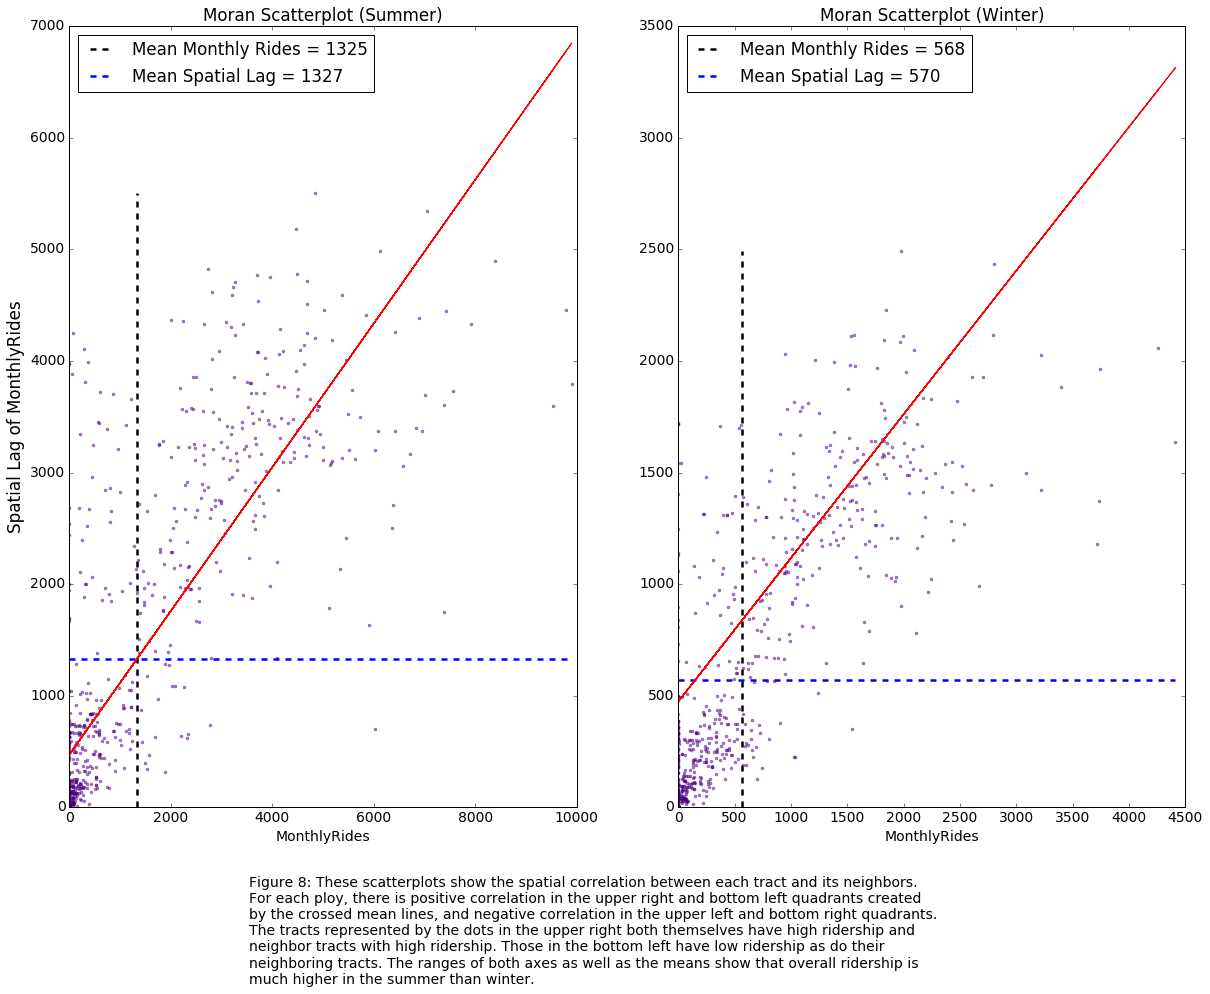

In [42]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 14))

ax1.plot(SummerRide, SummerRideLag, '.', color='indigo', alpha=0.5)
ax2.plot(WinterRide, WinterRideLag, '.', color='indigo', alpha=0.5)

ax1.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--', lw=2.5,
          label='Mean Monthly Rides = %.0f' %SummerRide.mean())
ax2.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--', lw=2.5, 
          label='Mean Monthly Rides = %.0f' %WinterRide.mean())

ax1.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--', color='blue', lw=2.5,
          label='Mean Spatial Lag = %.0f' %SummerRideLag.mean())
ax2.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--', color='blue', lw=2.5, 
          label='Mean Spatial Lag = %.0f' %WinterRideLag.mean())
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

# red line of best fit using global I as slope
ax1.plot(SummerRide, a + b*SummerRide, 'r')
ax2.plot(WinterRide, a + b*WinterRide, 'r')
ax1.set_title('Moran Scatterplot (Summer)')
ax2.set_title('Moran Scatterplot (Winter)')
ax1.set_ylabel('Spatial Lag of MonthlyRides', fontsize='large')
ax1.set_xlabel('MonthlyRides')
ax2.set_xlabel('MonthlyRides')
plt.figtext(0.25, -0.05, '''Figure 8: These scatterplots show the spatial correlation between each tract and its neighbors.
For each ploy, there is positive correlation in the upper right and bottom left quadrants created
by the crossed mean lines, and negative correlation in the upper left and bottom right quadrants.
The tracts represented by the dots in the upper right both themselves have high ridership and
neighbor tracts with high ridership. Those in the bottom left have low ridership as do their
neighboring tracts. The ranges of both axes as well as the means show that overall ridership is
much higher in the summer than winter.''')

### Moran's I

In [43]:
I_SummerRide = ps.Moran(SummerRide, queenWeights_Summer) #using pysal   #click inside here, then press shift+tab
I_WinterRide = ps.Moran(WinterRide, queenWeights_Winter)

In [44]:
print I_SummerRide.I, I_SummerRide.p_sim # first number is same as polyfit above, second number is the point of pysal, gives you 
#the p-value of of the I, i.e. how significant it is
print I_WinterRide.I, I_WinterRide.p_sim

0.644069499068 0.001
0.662044196711 0.001


In [45]:
print "The I statistic is %.3f for Summer, and it has a very small p value of %.3f" %(I_SummerRide.I, I_SummerRide.p_sim)
print "The I statistic is %.3f for Winter, and it has a very small p value of %.3f" %(I_WinterRide.I, I_WinterRide.p_sim)

The I statistic is 0.644 for Summer, and it has a very small p value of 0.001
The I statistic is 0.662 for Winter, and it has a very small p value of 0.001


In [46]:
I_SummerRide.sim[0:10], I_WinterRide.sim[0:10]

(array([ 0.01919923, -0.00815278, -0.0104582 ,  0.00831707, -0.00966402,
        -0.01890921, -0.03803028,  0.02501423,  0.01014372, -0.00906662]),
 array([-0.01988553, -0.01125325, -0.017644  , -0.00794927, -0.03081913,
        -0.00772034,  0.00943837, -0.02136121, -0.01156533, -0.01521332]))

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [47]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,7)

(-0.2, 0.7)

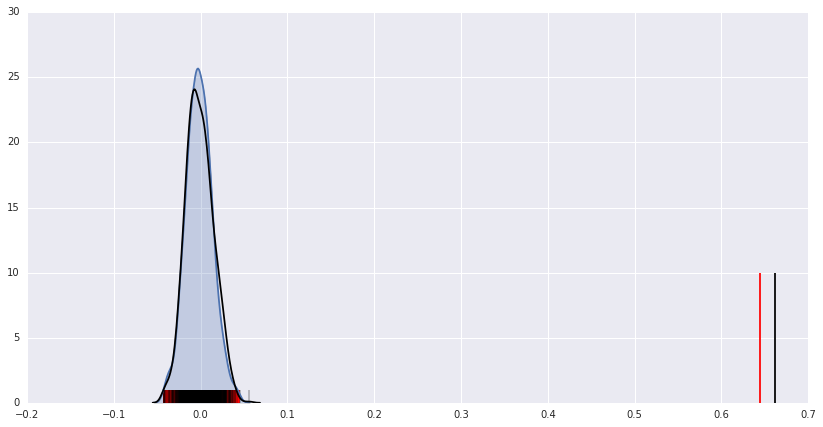

In [48]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1, 'r')
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.20, .70])
#plt.show()
sns.kdeplot(I_WinterRide.sim, shade=False, color='k')
plt.vlines(I_WinterRide.sim, 0, 1, color='k', alpha=0.25)
plt.vlines(I_WinterRide.I, 0, 10, 'k')
plt.xlim([-.20, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.2, 0.3)

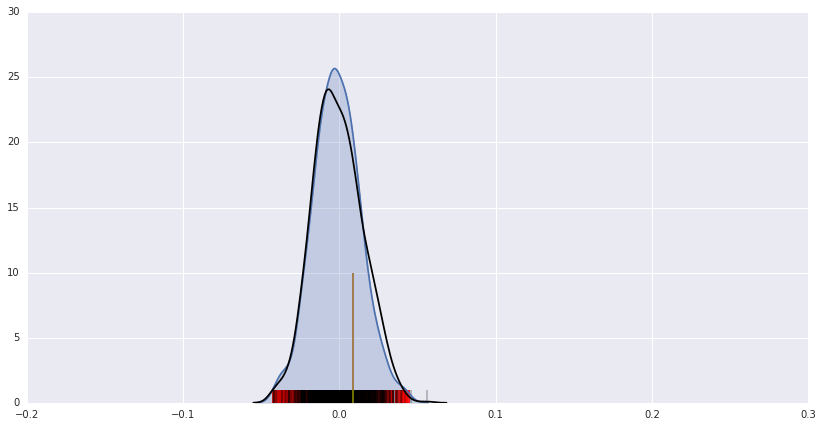

In [49]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1, 'r')
plt.vlines(I_SummerRide.EI+.01, 0, 10, 'indigo')
plt.xlim([-.20, .30])
sns.kdeplot(I_WinterRide.sim, shade=False, color='k')
plt.vlines(I_WinterRide.sim, 0, 1, 'k', alpha=0.25)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'yellow', alpha=0.5)
plt.xlim([-.20, .30])

## Local  Spatial Autocorrelation

In [50]:
LMo_SummerRide = ps.Moran_Local(SummerRide, queenWeights_Summer,permutations=999)
LMo_WinterRide = ps.Moran_Local(WinterRide, queenWeights_Winter,permutations=999)

In [51]:
print LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]
print LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

[-0.         -0.23689404  0.01179723  0.00235718  0.0247348 ] [ 0.001  0.172  0.338  0.353  0.392]
[-0.         -0.3153042  -0.00110645 -0.00100209 -0.06082761] [ 0.001  0.135  0.462  0.471  0.423]


### LISA (Local Indicators of Spatial Autocorrelation)

In [52]:
# Summer Sigs
SummerSigs = SummerRide[LMo_SummerRide.p_sim <= .001]
W_SummerSigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
SummerInsigs = SummerRide[LMo_SummerRide.p_sim > .001]
W_SummerInsigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

#Winter Sigs
WinterSigs = WinterRide[LMo_WinterRide.p_sim <= .001]
W_WinterSigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
WinterInsigs = WinterRide[LMo_WinterRide.p_sim > .001]
W_WinterInsigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

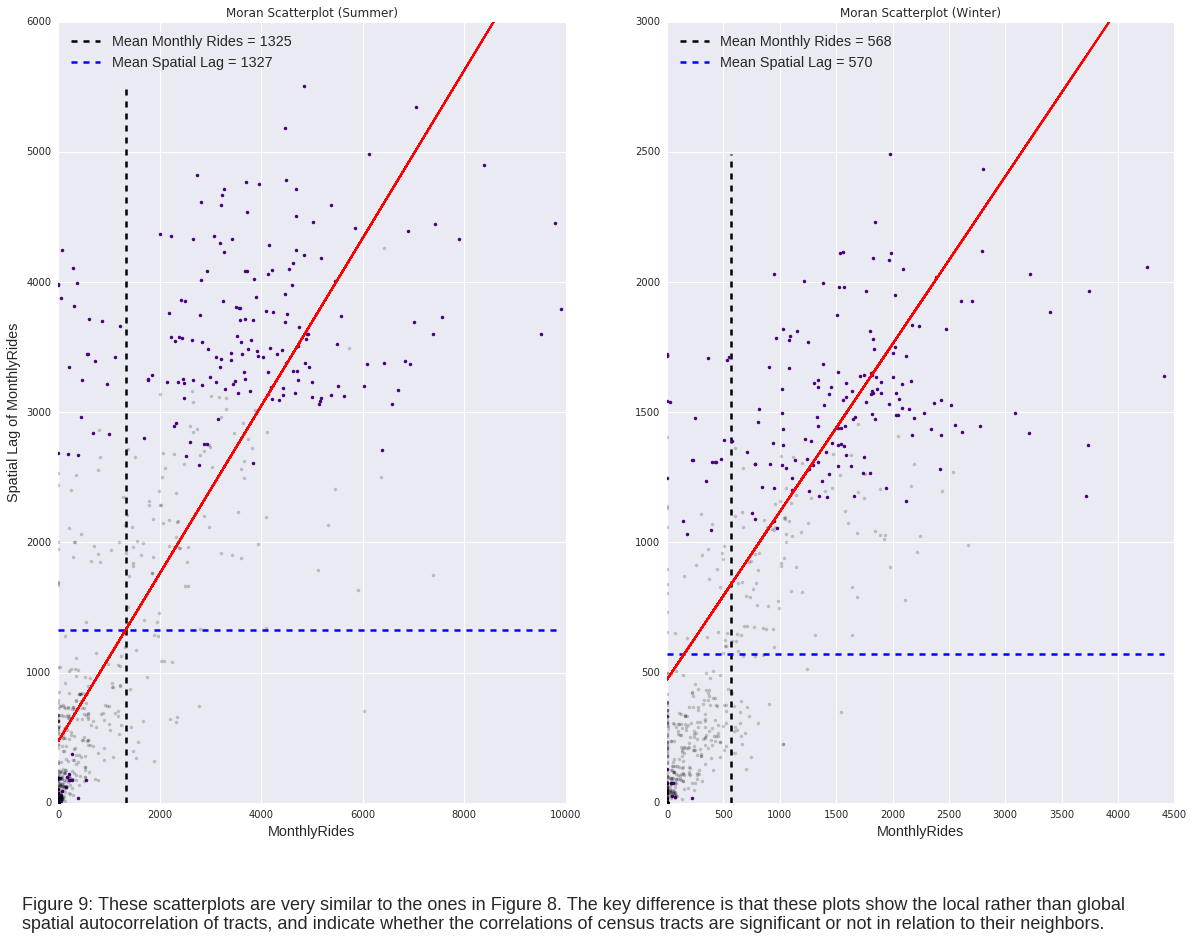

In [53]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 14))
ax1.plot(SummerSigs, W_SummerSigs, '.', color='indigo')
ax1.plot(SummerInsigs, W_SummerInsigs, '.k', alpha=.2)
ax2.plot(WinterSigs, W_WinterSigs, '.', color='indigo')
ax2.plot(WinterInsigs, W_WinterInsigs, '.k', alpha=.2)
#ax2.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

ax1.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--', lw=2.5,
          label='Mean Monthly Rides = %.0f' %SummerRide.mean())
ax2.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--', lw=2.5, 
          label='Mean Monthly Rides = %.0f' %WinterRide.mean())

ax1.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--', color='blue', lw=2.5,
          label='Mean Spatial Lag = %.0f' %SummerRideLag.mean())
ax2.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--', color='blue', lw=2.5, 
          label='Mean Spatial Lag = %.0f' %WinterRideLag.mean())
ax1.legend(loc='upper left', fontsize='large')
ax2.legend(loc='upper left', fontsize='large')

# red line of best fit using global I as slope
ax1.plot(SummerRide, a + b*SummerRide, 'r')
ax1.set_title('Moran Scatterplot (Summer)')
ax1.set_ylabel('Spatial Lag of MonthlyRides', fontsize='large')
ax1.set_xlabel('MonthlyRides', fontsize='large')
ax2.plot(WinterRide, a + b*WinterRide, 'r')
ax2.set_title('Moran Scatterplot (Winter)')
ax2.set_xlabel('MonthlyRides', fontsize='large')
ax1.set_ylim(0, 6000)
ax2.set_ylim(0, 3000)
plt.figtext(0.1, -0.000001, '''Figure 9: These scatterplots are very similar to the ones in Figure 8. The key difference \
is that these plots show the local rather than global
spatial autocorrelation of tracts, and indicate whether the correlations of census tracts are significant or not in relation \
to their neighbors.''', fontsize=18)

### Hot and Cold spots 

In [54]:
SummerSig = LMo_SummerRide.p_sim < 0.01
SummerHot = LMo_SummerRide.q==1 * SummerSig
SummerCold = LMo_SummerRide.q==3 * SummerSig
print "Number of Hotspots:", SummerHot.sum()
print "Number of Coldspots:", SummerCold.sum()

WinterSig = LMo_WinterRide.p_sim < 0.01
WinterHot = LMo_WinterRide.q==1 * WinterSig
WinterCold = LMo_WinterRide.q==3 * WinterSig
print "Number of Hotspots:", WinterHot.sum()
print "Number of Coldspots:", WinterCold.sum()

Number of Hotspots: 190
Number of Coldspots: 245
Number of Hotspots: 196
Number of Coldspots: 217


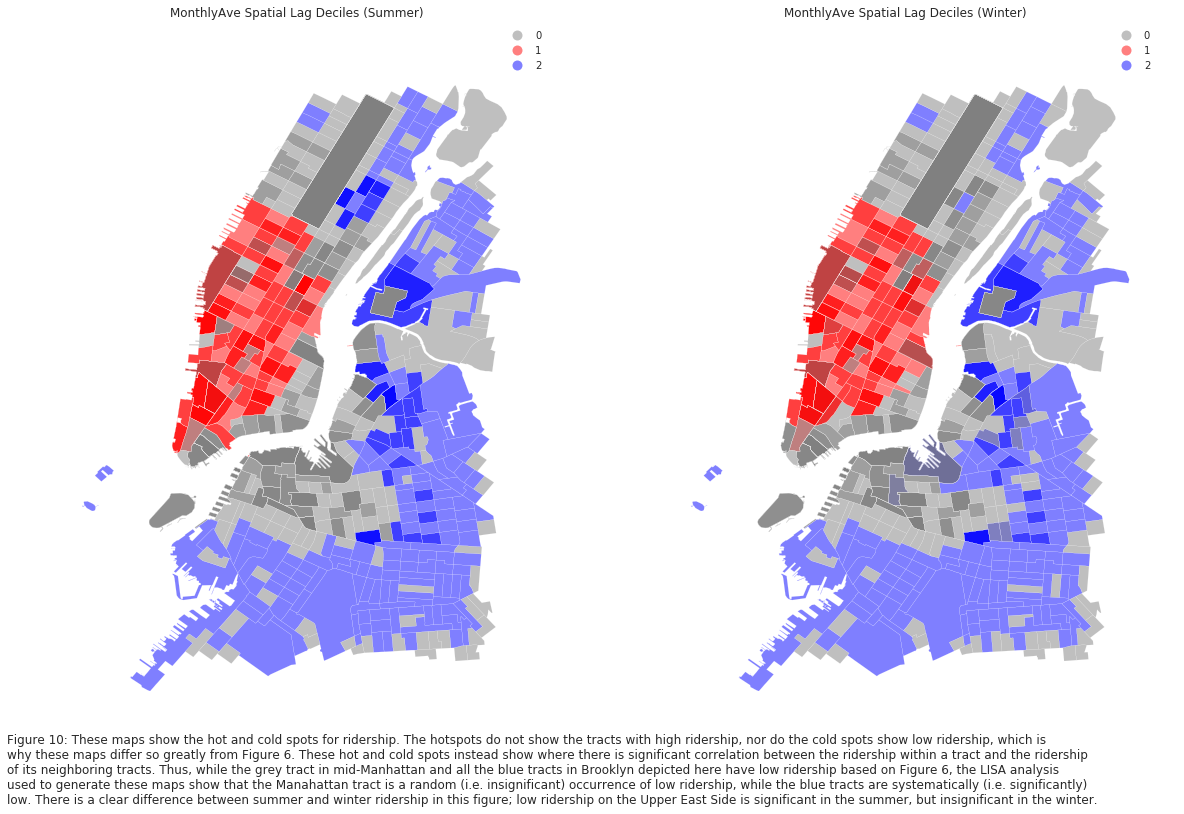

In [55]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
SumHotcold = SummerHot*1 + SummerCold*2
WintHotcold = WinterHot*1 + WinterCold*2

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 12))
ct_shape_Summer_Zoom.assign(cl=SumHotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ct_shape_Winter_Zoom.assign(cl=WintHotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title("MonthlyAve Spatial Lag Deciles (Summer)")
ax2.set_title("MonthlyAve Spatial Lag Deciles (Winter)")
plt.figtext(0.1, -0.005, '''Figure 10: These maps show the hot and cold spots for ridership. The hotspots do not show the \
tracts with high ridership, nor do the cold spots show low ridership, which is
why these maps differ so greatly from Figure 6. These hot and cold spots instead show where there is significant correlation \
between the ridership within a tract and the ridership
of its neighboring tracts. Thus, while the grey tract in mid-Manhattan and all the blue tracts in Brooklyn depicted here \
have low ridership based on Figure 6, the LISA analysis
used to generate these maps show that the Manahattan tract is a random (i.e. insignificant) occurrence of low \
ridership, while the blue tracts are systematically (i.e. significantly)
low. There is a clear difference between summer and winter ridership in this figure; low ridership on the Upper East Side \
is significant in the summer, but insignificant in the winter.''')